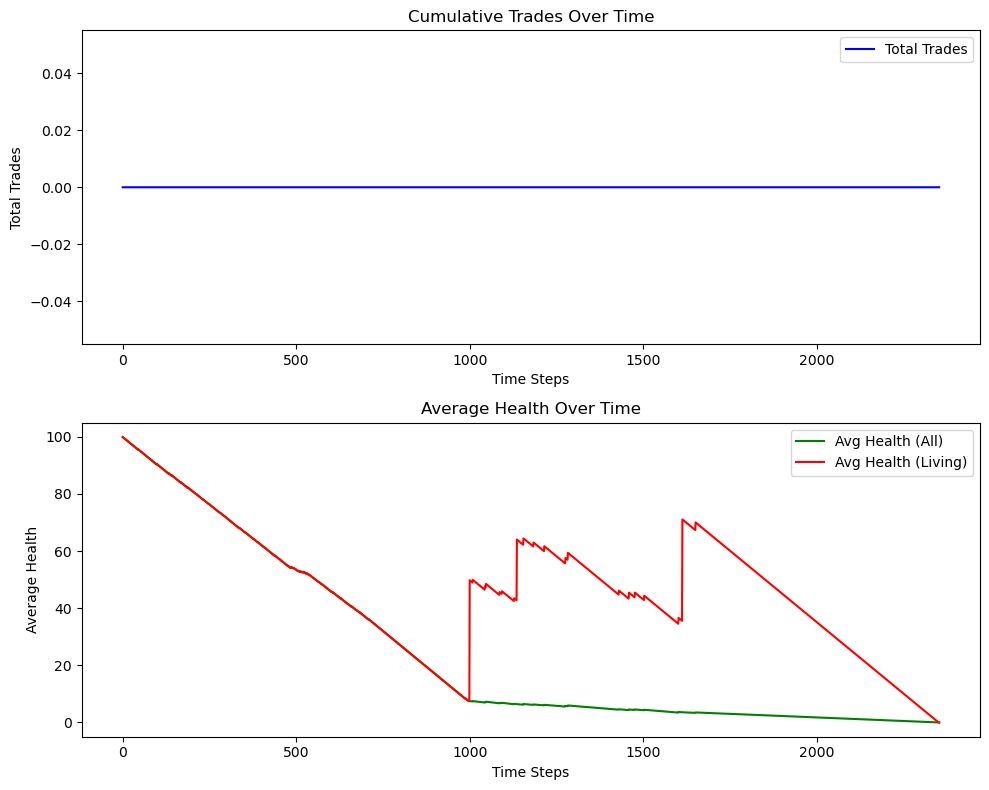

In [4]:
#my most recent basic with trade, too frequent trade probably resulting from trade logic
import pygame
import random
import math
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import numpy as np

# Constants to define game settings
WIDTH, HEIGHT = 800, 600
SUGAR_RADIUS = 20
ANT_SIZE = 10
ANT_SPEED = 0.5
NUM_ANTS = 20
SUGAR_MAX = 100
SUGAR_REGENERATION_RATE = 0.1
SQUARE_SIZE = 5
REGENERATION_INTERVAL = 1000
ANT_HEALTH = 100
HEALTH_INCREASE = 10
HEALTH_DECREASE_RATE = 0.1
SPICE_RADIUS = 15
SPICE_MAX = 50
SPICE_REGENERATION_RATE = 0.05
SPICE_SIZE = 10
SPICE_TRADING_DISTANCE = 60
TRADING_ANGLE_THRESHOLD = math.pi / 2

SUGAR_GRID_SIZE = 10
HALF_SUGAR_GRID_SIZE = SUGAR_GRID_SIZE // 2

# Color definitions
WHITE = (255, 255, 255)
RED = (255, 0, 0)
GREEN = (0, 255, 0)
BLUE = (0, 0, 255)
BLACK = (0, 0, 0)

# Initialize font
pygame.font.init()
FONT = pygame.font.Font(None, 36)

def get_ant_color(health):
    """
    Determine the color of an ant based on its health.
    As health decreases, the ant fades to white.
    """
    intensity = int((health / ANT_HEALTH) * 255)
    return (255, 255, 255 - intensity)

class Ant:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.health = 100
        self.direction = random.uniform(0, 2 * math.pi)
        self.turn_angle = math.pi / 8
        self.avoid_distance = 20
        self.sugar = 0
        self.spice = 0
        self.sugar_mining_skill = random.uniform(0.5, 1.5)
        self.spice_mining_skill = random.uniform(0.5, 1.5)
        self.sugar_preference = 1#2 - self.sugar_mining_skill
        self.spice_preference = 1#2 - self.spice_mining_skill
        self.state = "exploring"

    def act(self, sugarscape):
        if self.health <= 0:
            return

        self.decrease_health()

        actions = {
            "exploring": self.explore,
            "mining_sugar": self.mine_sugar,
            "mining_spice": self.mine_spice,
            "trading": self.trade,
            "consuming": self.consume_resources
        }

        actions[self.state](sugarscape)

    def explore(self, sugarscape):
        self.move(sugarscape.ants)
        self.detect_resources(sugarscape)

    def mine_sugar(self, sugarscape):
        for sugar in sugarscape.sugar_patches:
            if sugar[2] and self.is_within_radius(sugar, SUGAR_RADIUS):
                sugar[2] = False
                sugar[3] -= 1
                sugarscape.consumed_sugar_patches.append(sugar)
                mined_amount = self.mine_resource('sugar')
                sugarscape.sugar_mined += mined_amount
                self.state = "consuming"
                return
        self.state = "exploring"

    def mine_spice(self, sugarscape):
        for spice in sugarscape.spice_patches:
            if spice[2] and self.is_within_radius(spice, SPICE_RADIUS):
                spice[2] = False
                spice[3] -= 1
                sugarscape.consumed_spice_patches.append(spice)
                mined_amount = self.mine_resource('spice')
                sugarscape.spice_mined += mined_amount
                self.state = "consuming"
                return
        self.state = "exploring"

    def trade(self, sugarscape):
        for other_ant in sugarscape.ants:
            if other_ant != self and self.can_trade_with(other_ant):
                if self.trade_resources(other_ant):
                    sugarscape.trade_count += 1
                    self.state = "consuming"
                    return
        self.state = "exploring"

    def detect_resources(self, sugarscape):
        for sugar in sugarscape.sugar_patches:
            if sugar[2] and self.is_within_radius(sugar, SUGAR_RADIUS):
                self.state = "mining_sugar"
                return

        for spice in sugarscape.spice_patches:
            if spice[2] and self.is_within_radius(spice, SPICE_RADIUS):
                self.state = "mining_spice"
                return

        self.state = "trading"

    def is_within_radius(self, resource, radius):
        dx = resource[0] - self.x
        dy = resource[1] - self.y
        return math.sqrt(dx ** 2 + dy ** 2) < radius

    def can_trade_with(self, other_ant):
        dx = other_ant.x - self.x
        dy = other_ant.y - self.y
        distance = math.sqrt(dx ** 2 + dy ** 2)
        return (distance < SPICE_TRADING_DISTANCE and
                self.is_facing(other_ant) and other_ant.is_facing(self))

    def detect_nearby_ants(self, ants):
        for other_ant in ants:
            if other_ant != self:
                dx = other_ant.x - self.x
                dy = other_ant.y - self.y
                distance = math.sqrt(dx ** 2 + dy ** 2)
                if distance < self.avoid_distance:
                    self.direction += math.pi
                    return

    def move(self, ants):
        self.detect_nearby_ants(ants)
        self.direction += random.uniform(-self.turn_angle, self.turn_angle)
        self.x += ANT_SPEED * math.cos(self.direction)
        self.y += ANT_SPEED * math.sin(self.direction)
        self.x = max(0, min(self.x, WIDTH))
        self.y = max(0, min(self.y, HEIGHT))

    def decrease_health(self):
        self.health -= HEALTH_DECREASE_RATE
        self.health = max(0, self.health)

    def is_facing(self, other_ant):
        dx = other_ant.x - self.x
        dy = other_ant.y - self.y
        angle_to_other = math.atan2(dy, dx)
        return abs((self.direction - angle_to_other + math.pi) % (2 * math.pi) - math.pi) < TRADING_ANGLE_THRESHOLD

    def mine_resource(self, resource_type):
        if resource_type == 'sugar':
            mined_amount = random.uniform(0.5, 1.0) * self.sugar_mining_skill
            self.sugar += mined_amount
        elif resource_type == 'spice':
            mined_amount = random.uniform(0.5, 1.0) * self.spice_mining_skill
            self.spice += mined_amount
        return mined_amount

    def consume_resources(self, _):
        sugar_consumed = min(self.sugar, self.sugar_preference)
        spice_consumed = min(self.spice, self.spice_preference)
        
        self.sugar -= sugar_consumed
        self.spice -= spice_consumed
        
        total_consumed = sugar_consumed + spice_consumed
        health_increase = HEALTH_INCREASE * (total_consumed / (self.sugar_preference + self.spice_preference))
        
        self.health += health_increase
        self.health = min(self.health, ANT_HEALTH)
        
        self.state = "exploring"



    def trade_resources(self, other_ant):
        traded = False
        imbalance_threshold = 0.2
        balance_threshold = 0.1

        # Comparative advantage trading
        if self.spice - self.sugar > imbalance_threshold and other_ant.sugar - other_ant.spice > imbalance_threshold:
            trade_amount = min(
                (self.spice - self.sugar) * 0.7,
                (other_ant.sugar - other_ant.spice) * 0.7,
                self.spice,  # Add resource checks
                other_ant.sugar,
                10
            )
            if trade_amount > 0:  # Ensure meaningful trade
                self.spice -= trade_amount
                other_ant.spice += trade_amount
                self.sugar += trade_amount
                other_ant.sugar -= trade_amount
                traded = True

        elif self.sugar - self.spice > imbalance_threshold and other_ant.spice - other_ant.sugar > imbalance_threshold:
            trade_amount = min(
                (self.sugar - self.spice) * 0.7,
                (other_ant.spice - other_ant.sugar) * 0.7,
                self.sugar,  # Add resource checks
                other_ant.spice,
                10
            )
            if trade_amount > 0:
                self.sugar -= trade_amount
                other_ant.sugar += trade_amount
                self.spice += trade_amount
                other_ant.spice -= trade_amount
                traded = True

        # Inverse trade
        elif abs(self.spice - self.sugar) < balance_threshold and abs(other_ant.sugar - other_ant.spice) < balance_threshold:
            trade_amount = min(1, (self.sugar + self.spice) * 0.1)
            if trade_amount > 0 and self.spice >= trade_amount and other_ant.sugar >= trade_amount:
                self.spice -= trade_amount
                other_ant.spice += trade_amount
                self.sugar += trade_amount
                other_ant.sugar -= trade_amount
                traded = True

        # Swindling
        else:
            if np.random.random() < 0.45:
                trade_amount = 1
                if self.spice >= trade_amount:  # Check for sufficient resources
                    self.spice -= trade_amount
                    other_ant.spice += trade_amount
                    traded = True
                elif self.sugar >= trade_amount:
                    self.sugar -= trade_amount
                    other_ant.sugar += trade_amount
                    traded = True

        return traded

   # return traded


   # def trade_resources(self, other_ant):
    #    traded = False
     #   imbalance_threshold = 0.2
      #  if self.spice - self.sugar > imbalance_threshold and other_ant.sugar - other_ant.spice > imbalance_threshold:
       #     trade_amount = min((self.spice - self.sugar) * 0.7, (other_ant.sugar - other_ant.spice) * 0.7, 10)
        #    self.spice -= trade_amount
         #   other_ant.spice += trade_amount
          #  self.sugar += trade_amount
           # other_ant.sugar -= trade_amount
            #traded = True
        #elif self.sugar - self.spice > imbalance_threshold and other_ant.spice - other_ant.sugar > imbalance_threshold:
         #   trade_amount = min((self.sugar - self.spice) * 0.7, (other_ant.spice - other_ant.sugar) * 0.7, 10)
          #  self.sugar -= trade_amount
           # other_ant.sugar += trade_amount
            #self.spice += trade_amount
            #other_ant.spice -= trade_amount
            #traded = True
       

class SugarScape:
    def __init__(self):
        self.sugar_spots = [(200, 300), (600, 300)]
        self.spice_spots = [(400, 100), (400, 500)]
        self.ants = [Ant(random.randint(0, WIDTH), random.randint(0, HEIGHT)) for _ in range(NUM_ANTS)]
        self.dead_ants = []
        self.sugar_patches = self.initialize_sugar_patches()
        self.spice_patches = self.initialize_spice_patches()
        self.consumed_sugar_patches = []
        self.consumed_spice_patches = []
        self.last_regeneration_time = pygame.time.get_ticks()
        self.trade_count = 0
        self.trade_counts = []
        self.health_all = []
        self.health_living = []
        self.sugar_mined = 0
        self.spice_mined = 0
        self.metrics = {
            "Avg Health (All)": 0,
            "Avg Health (Living)": 0,
            "Sugar Available": len(self.sugar_patches),
            "Spice Available": len(self.spice_patches),
            "Living Ants": NUM_ANTS,
            "Total Trades": 0,
            "Sugar Mined": 0,
            "Spice Mined": 0
        }

    def initialize_sugar_patches(self):
        patches = []
        for (x, y) in self.sugar_spots:
            for n in range(SUGAR_MAX):
                square_x = x + (n % SUGAR_GRID_SIZE) * SQUARE_SIZE - HALF_SUGAR_GRID_SIZE * SQUARE_SIZE
                square_y = y + (n // SUGAR_GRID_SIZE) * SQUARE_SIZE - HALF_SUGAR_GRID_SIZE * SQUARE_SIZE
                patches.append([square_x, square_y, True, SQUARE_SIZE])
        return patches

    def initialize_spice_patches(self):
        patches = []
        for (x, y) in self.spice_spots:
            for n in range(SPICE_MAX):
                square_x = x + (n % SUGAR_GRID_SIZE) * SPICE_SIZE - HALF_SUGAR_GRID_SIZE * SPICE_SIZE
                square_y = y + (n // SUGAR_GRID_SIZE) * SPICE_SIZE - HALF_SUGAR_GRID_SIZE * SPICE_SIZE
                patches.append([square_x, square_y, True, SPICE_SIZE])
        return patches

    def update(self):
        self.trade_count = 0
        for ant in self.ants[:]:
            if ant.health > 0:
                ant.act(self)
            else:
                self.dead_ants.append(ant)
                self.ants.remove(ant)

        # Calculate and update health metrics
        all_healths = [ant.health for ant in self.ants] + [0 for _ in self.dead_ants]
        living_healths = [ant.health for ant in self.ants if ant.health > 0]
        
        avg_health_all = sum(all_healths) / (len(self.ants) + len(self.dead_ants)) if all_healths else 0
        avg_health_living = sum(living_healths) / len(living_healths) if living_healths else 0
        
        self.metrics["Avg Health (All)"] = avg_health_all
        self.metrics["Avg Health (Living)"] = avg_health_living
        
        # Store health metrics for plotting
        self.health_all.append(avg_health_all)
        self.health_living.append(avg_health_living)
        
        self.metrics["Sugar Available"] = len([s for s in self.sugar_patches if s[2]])
        self.metrics["Spice Available"] = len([s for s in self.spice_patches if s[2]])
        self.metrics["Living Ants"] = len(self.ants)
        self.metrics["Total Trades"] += self.trade_count
        self.metrics["Sugar Mined"] = self.sugar_mined
        self.metrics["Spice Mined"] = self.spice_mined
        self.trade_counts.append(self.trade_count + (self.trade_counts[-1] if self.trade_counts else 0))
        
        self.regenerate_resources()

    def regenerate_resources(self):
        current_time = pygame.time.get_ticks()
        if current_time - self.last_regeneration_time > REGENERATION_INTERVAL:
            # Regenerate sugar
            for sugar in self.sugar_patches:
                if not sugar[2]:  # If the sugar patch is consumed
                    if random.random() < SUGAR_REGENERATION_RATE:
                        sugar[2] = True  # Respawn the sugar
                        if sugar in self.consumed_sugar_patches:
                            self.consumed_sugar_patches.remove(sugar)
            
            # Regenerate spice
            for spice in self.spice_patches:
                if not spice[2]:  # If the spice patch is consumed
                    if random.random() < SPICE_REGENERATION_RATE:
                        spice[2] = True
                        if spice in self.consumed_spice_patches:
                            self.consumed_spice_patches.remove(spice)
            
            self.last_regeneration_time = current_time

def plot_health_and_trades(trade_counts, health_all, health_living):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    # Plot cumulative trades
    ax1.plot(trade_counts, color='blue', label='Total Trades')
    ax1.set_title('Cumulative Trades Over Time')
    ax1.set_xlabel('Time Steps')
    ax1.set_ylabel('Total Trades')
    ax1.legend()

    # Plot average healths
    ax2.plot(health_all, color='green', label='Avg Health (All)')
    ax2.plot(health_living, color='red', label='Avg Health (Living)')
    ax2.set_title('Average Health Over Time')
    ax2.set_xlabel('Time Steps')
    ax2.set_ylabel('Average Health')
    ax2.legend()

    plt.tight_layout()
    plt.show()



#def draw_metrics(surface, metrics):
 #   y_offset = 10
  #  for metric, value in metrics.items():
   #     text = FONT.render(f"{metric}: {int(value)}" if isinstance(value, float) else f"{metric}: {value}", True, BLACK)
    #    surface.blit(text, (10, y_offset))
     #   y_offset += 30

def draw_sugarscape(surface, sugarscape):
    surface.fill(WHITE)
    for ant in sugarscape.ants:
        pygame.draw.circle(surface, get_ant_color(ant.health), (int(ant.x), int(ant.y)), ANT_SIZE)
    for sugar in sugarscape.sugar_patches:
        if sugar[2]:
            pygame.draw.rect(surface, GREEN, pygame.Rect(sugar[0], sugar[1], sugar[3], sugar[3]))
    for spice in sugarscape.spice_patches:
        if spice[2]:
            pygame.draw.rect(surface, RED, pygame.Rect(spice[0], spice[1], SPICE_SIZE, SPICE_SIZE))

    # Draw trade lines (making them slimmer)
    for i, ant in enumerate(sugarscape.ants):
        for other_ant in sugarscape.ants[i+1:]:
            if (ant.health > 0 and other_ant.health > 0 and
                math.sqrt((ant.x - other_ant.x) ** 2 + (ant.y - other_ant.y) ** 2) < SPICE_TRADING_DISTANCE and
                ant.is_facing(other_ant) and other_ant.is_facing(ant)):
                pygame.draw.line(surface, BLUE, (ant.x, ant.y), (other_ant.x, other_ant.y), 1)  # Change line width to 1

  #  draw_metrics(surface, sugarscape.metrics)
    pygame.display.flip()

def main():
    pygame.init()
    screen = pygame.display.set_mode((800, 600), pygame.RESIZABLE)
    sugarscape = SugarScape()
    clock = pygame.time.Clock()
    running = True

    while running and len(sugarscape.ants) > 0:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False

        sugarscape.update()
        draw_sugarscape(screen, sugarscape)
        clock.tick(60)

    pygame.quit()

    # Plot cumulative trades and average health
    plot_health_and_trades(sugarscape.trade_counts, sugarscape.health_all, sugarscape.health_living)

if __name__ == "__main__":
    main()

THIS IS WHERE I WILL BE IMPLEMENTING Q LEARNING

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from collections import namedtuple, deque

# Define the Transition namedtuple
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

# ReplayMemory class (unchanged from your example)
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# DQN class
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

# Constants
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DQNAgent:
    def __init__(self, n_observations, n_actions):
        self.policy_net = DQN(n_observations, n_actions).to(device)
        self.target_net = DQN(n_observations, n_actions).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        
        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=LR, amsgrad=True)
        self.memory = ReplayMemory(10000)
        
        self.steps_done = 0
        self.n_actions = n_actions

    def select_action(self, state):
        sample = random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * self.steps_done / EPS_DECAY)
        self.steps_done += 1
        if sample > eps_threshold: # we should include
            with torch.no_grad():
                return self.policy_net(state).max(1).indices.view(1, 1)
        else:
            return torch.tensor([[random.randrange(self.n_actions)]], device=device, dtype=torch.long)

    def optimize_model(self): #make a counter for this to track how 
        if len(self.memory) < BATCH_SIZE:
            return
        transitions = self.memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
        
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        next_state_values = torch.zeros(BATCH_SIZE, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1).values

        expected_state_action_values = (next_state_values * GAMMA) + reward_batch

        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()

    def update_target_network(self):
        target_net_state_dict = self.target_net.state_dict()
        policy_net_state_dict = self.policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        self.target_net.load_state_dict(target_net_state_dict)

# Modify the Ant class to work with the DQN
class Ant:
    def __init__(self, x, y):
        # ... (keep existing initialization)
        self.x = x
        self.y = y
        self.health = 100
        self.direction = random.uniform(0, 2 * math.pi)
        self.turn_angle = math.pi / 8
        self.avoid_distance = 20
        self.sugar = 0
        self.spice = 0
        self.sugar_mining_skill = random.uniform(0.5, 1.5)#split it between halfthe pop then make it a fixed value
        self.spice_mining_skill = random.uniform(0.5, 1.5)#same here
        self.sugar_preference = 1 #2 - self.sugar_mining_skill
        self.spice_preference = 1 #2 - self.spice_mining_skill
        self.state = self.get_state_representation()
        self.agent = DQNAgent(n_observations=self.state.shape[1], n_actions=5)
        #self.state = "exploring"
        #self.state = torch.tensor([x, y, self.health, self.sugar, self.spice, #self.can_trade_with, detect_nearby_resources, comparative advantage ], dtype=torch.float32).unsqueeze(0)
        #self.agent = DQNAgent(n_observations=5, n_actions=4)  # 4 actions: move in 4 directions

    #def act(self, sugarscape):
     #   action = self.agent.select_action(self.state)
    def get_state_representation(self):
    # Get nearby resource detection
        nearby_sugar = 0
        nearby_spice = 0
        for sugar in self.sugarscape.sugar_patches:
            if sugar[2] and self.is_within_radius(sugar, SUGAR_RADIUS):
                nearby_sugar = 1
                break
        for spice in self.sugarscape.spice_patches:
            if spice[2] and self.is_within_radius(spice, SPICE_RADIUS):
                nearby_spice = 1
                break   

        can_trade = 0
        has_comparative_advantage = 0
        for other_ant in self.sugarscape.ants:
            if other_ant != self and self.can_trade_with(other_ant):
                can_trade = 1
            # Check for comparative advantage
                if (abs(self.spice - self.sugar) > 0.2 and 
                    abs(other_ant.sugar - other_ant.spice) > 0.2):
                    has_comparative_advantage = 1
                break
 # state tensor
        state = torch.tensor([
            self.x / WIDTH,  # Normalize position
            self.y / HEIGHT,
            self.health / 100.0,  # Normalize health
            self.sugar / 10.0,  # Normalize resources
            self.spice / 10.0,
            nearby_sugar,
            nearby_spice,
            can_trade,
            has_comparative_advantage,
            self.direction / (2 * math.pi),  # Normalized direction
        ], dtype=torch.float32).unsqueeze(0)
    
        return state
    def act(self, sugarscape):
    """Execute actions based on DQN selection"""
        self.sugarscape = sugarscape  # Store reference for state calculation
    
    # Get current state
        self.state = self.get_state_representation()
    
    # Select action using DQN
        action = self.agent.select_action(self.state)
    
    # Execute selected action
        reward = 0
        if action == 0:  # Explore
            self.explore(sugarscape)
            reward = -0.1  # Small negative reward for moving
        
        elif action == 1:  # Mine sugar
            if self.state[0][5] > 0:  # If sugar is nearby
                self.mine_sugar(sugarscape)
                reward = 1.0 * self.sugar_mining_skill
            else:
                reward = -0.2
            
        elif action == 2:  # Mine spice
            if self.state[0][6] > 0:  # If spice is nearby
                self.mine_spice(sugarscape)
                reward = 1.0 * self.spice_mining_skill
            else:
                reward = -0.2
                
        elif action == 3:  # Trade
            if self.state[0][7] > 0:  # If trading is possible
                success = self.trade(sugarscape)
                reward = 2.0 if success else -0.3
            else:
                reward = -0.2
            
        elif action == 4:  # Consume
            if self.sugar > 0 or self.spice > 0:
                self.consume_resources(None)
                reward = self.health / 50.0  # Reward based on health after consumption
            else:
                reward = -0.2

    # Additional reward components
        reward += self.health / 200.0  # Small reward for staying alive
        reward -= 0.5 if self.health <= 0 else 0  # Penalty for death
    
    # Get next state
        next_state = self.get_state_representation()
        
        # Store transition in memory
        self.agent.memory.push(
            self.state,
            torch.tensor([action]),
            next_state,
            torch.tensor([reward])
        )
        
        # Update state
        self.state = next_state
        
        # Train the network
        self.agent.optimize_model()
        self.agent.update_target_network()
    def calculate_reward(self):
        """Calculate the reward based on the ant's current state"""
        reward = 0
        
        # Base reward components
        reward += self.health / 100.0  # Normalized health contribution
        reward += (self.sugar + self.spice) / 20.0  # Resource holdings
        
        # Penalty for death
        if self.health <= 0:
            reward -= 1.0
            
        # Reward for successful resource acquisition
        if self.sugar > 0 or self.spice > 0:
            reward += 0.2
            
        # Reward for balanced resources
        if abs(self.sugar - self.spice) < 0.2:
            reward += 0.3
            
        return reward



        
  

    def explore(self, sugarscape):#make  it change direction before moving*******
        self.move(sugarscape.ants)
        self.detect_resources(sugarscape)

    def mine_sugar(self, sugarscape):
        for sugar in sugarscape.sugar_patches:
            if sugar[2] and self.is_within_radius(sugar, SUGAR_RADIUS):
                sugar[2] = False
                sugar[3] -= 1
                sugarscape.consumed_sugar_patches.append(sugar)
                mined_amount = self.mine_resource('sugar')
                sugarscape.sugar_mined += mined_amount
                self.state = "consuming"
                return
        self.state = "exploring"

    def mine_spice(self, sugarscape):
        for spice in sugarscape.spice_patches:
            if spice[2] and self.is_within_radius(spice, SPICE_RADIUS):
                spice[2] = False
                spice[3] -= 1
                sugarscape.consumed_spice_patches.append(spice)
                mined_amount = self.mine_resource('spice')
                sugarscape.spice_mined += mined_amount
                self.state = "consuming"
                return
        self.state = "exploring"

    def trade(self, sugarscape):
        for other_ant in sugarscape.ants:
            if other_ant != self and self.can_trade_with(other_ant):
                if self.trade_resources(other_ant):
                    sugarscape.trade_count += 1# call trading here******* 
                    self.state = "consuming"
                    return
        self.state = "exploring"

    def decrease_health(self):
        self.health -= HEALTH_DECREASE_RATE
        self.health = max(0, self.health)


    def detect_resources(self, sugarscape):
        for sugar in sugarscape.sugar_patches:
            if sugar[2] and self.is_within_radius(sugar, SUGAR_RADIUS):
                self.state = "mining_sugar"
                return

        for spice in sugarscape.spice_patches:
            if spice[2] and self.is_within_radius(spice, SPICE_RADIUS):
                self.state = "mining_spice"
                return

        self.state = "trading"

    def is_within_radius(self, resource, radius):
        dx = resource[0] - self.x
        dy = resource[1] - self.y
        return math.sqrt(dx ** 2 + dy ** 2) < radius

        

    def calculate_reward(self):
        # define reward function based on the ant's performance
        return self.health + self.sugar + self.spice# edit to make sure that proper rewards are not going to 

    # ... (keep other methods like mine_resources, trade, consume_resources)
    def can_trade_with(self, other_ant):
        dx = other_ant.x - self.x
        dy = other_ant.y - self.y
        distance = math.sqrt(dx ** 2 + dy ** 2)
        return (distance < SPICE_TRADING_DISTANCE)# and
                #self.is_facing(other_ant) and other_ant.is_facing(self))

    def detect_nearby_ants(self, ants):
        for other_ant in ants:
            if other_ant != self:
                dx = other_ant.x - self.x
                dy = other_ant.y - self.y
                distance = math.sqrt(dx ** 2 + dy ** 2)
                if distance < self.avoid_distance:
                    self.direction += math.pi
                    return

    def move(self, ants):
        self.detect_nearby_ants(ants)
        self.direction += random.uniform(-self.turn_angle, self.turn_angle)
        self.x += ANT_SPEED * math.cos(self.direction)
        self.y += ANT_SPEED * math.sin(self.direction)
        self.x = max(0, min(self.x, WIDTH))
        self.y = max(0, min(self.y, HEIGHT))

    
    def is_facing(self, other_ant):
        dx = other_ant.x - self.x
        dy = other_ant.y - self.y
        angle_to_other = math.atan2(dy, dx)
        return abs((self.direction - angle_to_other + math.pi) % (2 * math.pi) - math.pi) < TRADING_ANGLE_THRESHOLD

    def mine_resource(self, resource_type):
        if resource_type == 'sugar':
            mined_amount = random.uniform(0.5, 1.0) * self.sugar_mining_skill
            self.sugar += mined_amount
        elif resource_type == 'spice':
            mined_amount = random.uniform(0.5, 1.0) * self.spice_mining_skill
            self.spice += mined_amount
        return mined_amount

    def consume_resources(self, _):
        sugar_consumed = min(self.sugar, self.sugar_preference)
        spice_consumed = min(self.spice, self.spice_preference)
        
        self.sugar -= sugar_consumed
        self.spice -= spice_consumed
        
        total_consumed = sugar_consumed + spice_consumed
        health_increase = HEALTH_INCREASE * (total_consumed / (self.sugar_preference + self.spice_preference))# make the preferences 1 to 1 ******
        
        self.health += health_increase
        self.health = min(self.health, ANT_HEALTH)
        
        self.state = "exploring"

    def trade_resources(self, other_ant):
        traded = False
        imbalance_threshold = 0.2
        if self.spice - self.sugar > imbalance_threshold and other_ant.sugar - other_ant.spice > imbalance_threshold:
            trade_amount = min((self.spice - self.sugar) * 0.7, (other_ant.sugar - other_ant.spice) * 0.7, 10)
            self.spice -= trade_amount
            other_ant.spice += trade_amount
            self.sugar += trade_amount
            other_ant.sugar -= trade_amount
            traded = True
        elif self.sugar - self.spice > imbalance_threshold and other_ant.spice - other_ant.sugar > imbalance_threshold:
            trade_amount = min((self.sugar - self.spice) * 0.7, (other_ant.spice - other_ant.sugar) * 0.7, 10)
            self.sugar -= trade_amount
            other_ant.sugar += trade_amount
            self.spice += trade_amount
            other_ant.spice -= trade_amount
            traded = True
        else:
            if np.random.random() < 0.3:  # 30% chance of random trade
                trade_amount = 1  # Fixed small trade
                if self.spice > 0 and other_ant.sugar > 0:
                    self.spice -= trade_amount
                    other_ant.spice += trade_amount
                    self.sugar += trade_amount
                    other_ant.sugar -= trade_amount
                    traded = True
                elif self.sugar > 0 and other_ant.spice > 0:
                    self.sugar -= trade_amount
                    other_ant.sugar += trade_amount
                    self.spice += trade_amount
                    other_ant.spice -= trade_amount
                    traded = True

        if traded:
            self.consume_resources(None)
            other_ant.consume_resources(None)
        return traded
# Modify the SugarScape class
class SugarScape:
    def __init__(self):
        self.sugar_spots = [(200, 300), (600, 300)]
        self.spice_spots = [(400, 100), (400, 500)]
        self.ants = [Ant(random.randint(0, WIDTH), random.randint(0, HEIGHT)) for _ in range(NUM_ANTS)]
        self.dead_ants = []
        self.sugar_patches = self.initialize_sugar_patches()
        self.spice_patches = self.initialize_spice_patches()
        self.consumed_sugar_patches = []
        self.consumed_spice_patches = []
        self.last_regeneration_time = pygame.time.get_ticks()
        self.trade_count = 0
        self.trade_counts = []
        self.health_all = []
        self.health_living = []
        self.sugar_mined = 0
        self.spice_mined = 0
        self.metrics = {
            "Avg Health (All)": 0,
            "Avg Health (Living)": 0,
            "Sugar Available": len(self.sugar_patches),
            "Spice Available": len(self.spice_patches),
            "Living Ants": NUM_ANTS,
            "Total Trades": 0,
            "Sugar Mined": 0,
            "Spice Mined": 0
        }

    def initialize_sugar_patches(self):
        patches = []
        for (x, y) in self.sugar_spots:
            for n in range(SUGAR_MAX):
                square_x = x + (n % SUGAR_GRID_SIZE) * SQUARE_SIZE - HALF_SUGAR_GRID_SIZE * SQUARE_SIZE
                square_y = y + (n // SUGAR_GRID_SIZE) * SQUARE_SIZE - HALF_SUGAR_GRID_SIZE * SQUARE_SIZE
                patches.append([square_x, square_y, True, SQUARE_SIZE])
        return patches

    def initialize_spice_patches(self):
        patches = []
        for (x, y) in self.spice_spots:
            for n in range(SPICE_MAX):
                square_x = x + (n % SUGAR_GRID_SIZE) * SPICE_SIZE - HALF_SUGAR_GRID_SIZE * SPICE_SIZE
                square_y = y + (n // SUGAR_GRID_SIZE) * SPICE_SIZE - HALF_SUGAR_GRID_SIZE * SPICE_SIZE
                patches.append([square_x, square_y, True, SPICE_SIZE])
        return patches

    def update(self):
        self.trade_count = 0
        for ant in self.ants[:]:
            if ant.health > 0:
                ant.act(self)
            else:
                self.dead_ants.append(ant)
                self.ants.remove(ant)

        # Calculate and update health metrics
        all_healths = [ant.health for ant in self.ants] + [0 for _ in self.dead_ants]
        living_healths = [ant.health for ant in self.ants if ant.health > 0]
        
        avg_health_all = sum(all_healths) / (len(self.ants) + len(self.dead_ants)) if all_healths else 0
        avg_health_living = sum(living_healths) / len(living_healths) if living_healths else 0
        
        self.metrics["Avg Health (All)"] = avg_health_all
        self.metrics["Avg Health (Living)"] = avg_health_living
        
        # Store health metrics for plotting
        self.health_all.append(avg_health_all)
        self.health_living.append(avg_health_living)
        
        self.metrics["Sugar Available"] = len([s for s in self.sugar_patches if s[2]])
        self.metrics["Spice Available"] = len([s for s in self.spice_patches if s[2]])
        self.metrics["Living Ants"] = len(self.ants)
        self.metrics["Total Trades"] += self.trade_count
        self.metrics["Sugar Mined"] = self.sugar_mined
        self.metrics["Spice Mined"] = self.spice_mined
        self.trade_counts.append(self.trade_count + (self.trade_counts[-1] if self.trade_counts else 0))
        
        self.regenerate_resources()

    def regenerate_resources(self):
        current_time = pygame.time.get_ticks()
        if current_time - self.last_regeneration_time > REGENERATION_INTERVAL:
            # Regenerate sugar
            for sugar in self.sugar_patches:
                if not sugar[2]:  # If the sugar patch is consumed
                    if random.random() < SUGAR_REGENERATION_RATE:
                        sugar[2] = True  # Respawn the sugar
                        if sugar in self.consumed_sugar_patches:
                            self.consumed_sugar_patches.remove(sugar)
            
            # Regenerate spice
            for spice in self.spice_patches:
                if not spice[2]:  # If the spice patch is consumed
                    if random.random() < SPICE_REGENERATION_RATE:
                        spice[2] = True
                        if spice in self.consumed_spice_patches:
                            self.consumed_spice_patches.remove(spice)
            
            self.last_regeneration_time = current_time

def plot_health_and_trades(trade_counts, health_all, health_living):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    # Plot cumulative trades
    ax1.plot(trade_counts, color='blue', label='Total Trades')
    ax1.set_title('Cumulative Trades Over Time')
    ax1.set_xlabel('Time Steps')
    ax1.set_ylabel('Total Trades')
    ax1.legend()

    # Plot average healths
    ax2.plot(health_all, color='green', label='Avg Health (All)')
    ax2.plot(health_living, color='red', label='Avg Health (Living)')
    ax2.set_title('Average Health Over Time')
    ax2.set_xlabel('Time Steps')
    ax2.set_ylabel('Average Health')
    ax2.legend()

    plt.tight_layout()
    plt.show()



def draw_metrics(surface, metrics):
    y_offset = 10
    for metric, value in metrics.items():
        text = FONT.render(f"{metric}: {int(value)}" if isinstance(value, float) else f"{metric}: {value}", True, BLACK)
        surface.blit(text, (10, y_offset))
        y_offset += 30

def draw_sugarscape(surface, sugarscape):
    surface.fill(WHITE)
    for ant in sugarscape.ants:
        pygame.draw.circle(surface, get_ant_color(ant.health), (int(ant.x), int(ant.y)), ANT_SIZE)
    for sugar in sugarscape.sugar_patches:
        if sugar[2]:
            pygame.draw.rect(surface, GREEN, pygame.Rect(sugar[0], sugar[1], sugar[3], sugar[3]))
    for spice in sugarscape.spice_patches:
        if spice[2]:
            pygame.draw.rect(surface, RED, pygame.Rect(spice[0], spice[1], SPICE_SIZE, SPICE_SIZE))

    # Draw trade lines (making them slimmer)
    for i, ant in enumerate(sugarscape.ants):
        for other_ant in sugarscape.ants[i+1:]:
            if (ant.health > 0 and other_ant.health > 0 and
                math.sqrt((ant.x - other_ant.x) ** 2 + (ant.y - other_ant.y) ** 2) < SPICE_TRADING_DISTANCE and
                ant.is_facing(other_ant) and other_ant.is_facing(ant)):
                pygame.draw.line(surface, BLUE, (ant.x, ant.y), (other_ant.x, other_ant.y), 1)  # Change line width to 1

    draw_metrics(surface, sugarscape.metrics)
    pygame.display.flip()


# Modify the main function
def main():
    pygame.init()
    screen = pygame.display.set_mode((WIDTH, HEIGHT))
    sugarscape = SugarScape()
    clock = pygame.time.Clock()
    running = True

    while running and len(sugarscape.ants) > 0:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False

        sugarscape.update()
        draw_sugarscape(screen, sugarscape)
        clock.tick(60)

    pygame.quit()

    # Plot results
    plot_health_and_trades(sugarscape)

if __name__ == "__main__":
    main()

SyntaxError: '[' was never closed (3629522048.py, line 125)

In [ ]:
# this is what chat gave me as implementation to check that ants are only trading when there's resource availability
    def trade_resources(self, other_ant):
        traded = False
        imbalance_threshold = 0.2  # Threshold for comparative advantage
        balance_threshold = 0.1    # Threshold for resource balance (inverse trade)

    # Comparative advantage: Trading based on resource imbalance
        if self.spice - self.sugar > imbalance_threshold and other_ant.sugar - other_ant.spice > imbalance_threshold:
            trade_amount = min((self.spice - self.sugar) * 0.7, (other_ant.sugar - other_ant.spice) * 0.7, 10)
            self.spice -= trade_amount
            other_ant.spice += trade_amount
            self.sugar += trade_amount
            other_ant.sugar -= trade_amount
            traded = True

        elif self.sugar - self.spice > imbalance_threshold and other_ant.spice - other_ant.sugar > imbalance_threshold:
            trade_amount = min((self.sugar - self.spice) * 0.7, (other_ant.spice - other_ant.sugar) * 0.7, 10)
            self.sugar -= trade_amount
            other_ant.sugar += trade_amount
            self.spice += trade_amount
            other_ant.spice -= trade_amount
            traded = True

    # Inverse trade: Trading when resources are balanced (with resource checks)
        elif abs(self.spice - self.sugar) < balance_threshold and abs(other_ant.sugar - other_ant.spice) < balance_threshold:
            trade_amount = min(1, (self.sugar + self.spice) * 0.1)
        # Resource check: Only trade if both ants have enough to trade
            if self.spice >= trade_amount and other_ant.sugar >= trade_amount:
                self.spice -= trade_amount
                other_ant.spice += trade_amount
                self.sugar += trade_amount
                other_ant.sugar -= trade_amount
                traded = True

    # Random trade (with resource checks)
        else:
            if np.random.random() < 0.45:  # 45% chance of random trade
                trade_amount = 1  # Fixed small trade amount
            # Resource check: Only trade if both ants have enough resources
                if self.spice > 0 and other_ant.sugar > 0:
                    self.spice -= trade_amount
                    other_ant.spice += trade_amount
                    self.sugar += trade_amount
                    other_ant.sugar -= trade_amount
                    traded = True
                elif self.sugar > 0 and other_ant.spice > 0:
                    self.sugar -= trade_amount
                    other_ant.sugar += trade_amount
                    self.spice += trade_amount
                    other_ant.spice -= trade_amount
                    traded = True

        return traded


In [ ]:
def __init__(self, x, y):
    self.x = x
    self.y = y
    self.health = 100
    self.direction = random.uniform(0, 2 * math.pi)
    self.turn_angle = math.pi / 8
    self.avoid_distance = 20
    self.sugar = 0
    self.spice = 0
    self.sugar_mining_skill = random.uniform(0.5, 1.5)
    self.spice_mining_skill = random.uniform(0.5, 1.5)
    self.sugar_preference = 1
    self.spice_preference = 1
    
    # State components
    self.state = self.get_state_representation()
    
    # Actions: 0=explore, 1=mine_sugar, 2=mine_spice, 3=trade, 4=consume
    self.agent = DQNAgent(n_observations=self.state.shape[1], n_actions=5)

def get_state_representation(self):
    """Creates the state tensor with all relevant information"""
    # Get nearby resource detection
    nearby_sugar = 0
    nearby_spice = 0
    for sugar in self.sugarscape.sugar_patches:
        if sugar[2] and self.is_within_radius(sugar, SUGAR_RADIUS):
            nearby_sugar = 1
            break
    for spice in self.sugarscape.spice_patches:
        if spice[2] and self.is_within_radius(spice, SPICE_RADIUS):
            nearby_spice = 1
            break

    # Get trading opportunity detection
    can_trade = 0
    has_comparative_advantage = 0
    for other_ant in self.sugarscape.ants:
        if other_ant != self and self.can_trade_with(other_ant):
            can_trade = 1
            # Check for comparative advantage
            if (abs(self.spice - self.sugar) > 0.2 and 
                abs(other_ant.sugar - other_ant.spice) > 0.2):
                has_comparative_advantage = 1
            break

    # Create state tensor
    state = torch.tensor([
        self.x / WIDTH,  # Normalize position
        self.y / HEIGHT,
        self.health / 100.0,  # Normalize health
        self.sugar / 10.0,  # Normalize resources
        self.spice / 10.0,
        nearby_sugar,
        nearby_spice,
        can_trade,
        has_comparative_advantage,
        self.direction / (2 * math.pi),  # Normalized direction
    ], dtype=torch.float32).unsqueeze(0)
    
    return state

def act(self, sugarscape):
    """Execute actions based on DQN selection"""
    self.sugarscape = sugarscape  # Store reference for state calculation
    
    # Get current state
    self.state = self.get_state_representation()
    
    # Select action using DQN
    action = self.agent.select_action(self.state)
    
    # Execute selected action
    reward = 0
    if action == 0:  # Explore
        self.explore(sugarscape)
        reward = -0.1  # Small negative reward for moving
        
    elif action == 1:  # Mine sugar
        if self.state[0][5] > 0:  # If sugar is nearby
            self.mine_sugar(sugarscape)
            reward = 1.0 * self.sugar_mining_skill
        else:
            reward = -0.2
            
    elif action == 2:  # Mine spice
        if self.state[0][6] > 0:  # If spice is nearby
            self.mine_spice(sugarscape)
            reward = 1.0 * self.spice_mining_skill
        else:
            reward = -0.2
            
    elif action == 3:  # Trade
        if self.state[0][7] > 0:  # If trading is possible
            success = self.trade(sugarscape)
            reward = 2.0 if success else -0.3
        else:
            reward = -0.2
            
    elif action == 4:  # Consume
        if self.sugar > 0 or self.spice > 0:
            self.consume_resources(None)
            reward = self.health / 50.0  # Reward based on health after consumption
        else:
            reward = -0.2

    # Additional reward components
    reward += self.health / 200.0  # Small reward for staying alive
    reward -= 0.5 if self.health <= 0 else 0  # Penalty for death
    
    # Get next state
    next_state = self.get_state_representation()
    
    # Store transition in memory
    self.agent.memory.push(
        self.state,
        torch.tensor([action]),
        next_state,
        torch.tensor([reward])
    )
    
    # Update state
    self.state = next_state
    
    # Train the network
    self.agent.optimize_model()
    self.agent.update_target_network()

def calculate_reward(self):
    """Calculate the reward based on the ant's current state"""
    reward = 0
    
    # Base reward components
    reward += self.health / 100.0  # Normalized health contribution
    reward += (self.sugar + self.spice) / 20.0  # Resource holdings
    
    # Penalty for death
    if self.health <= 0:
        reward -= 1.0
        
    # Reward for successful resource acquisition
    if self.sugar > 0 or self.spice > 0:
        reward += 0.2
        
    # Reward for balanced resources
    if abs(self.sugar - self.spice) < 0.2:
        reward += 0.3
        
    return reward

In [ ]:
      # Perform other actions (mining, trading, etc.)
        self.mine_resources(sugarscape)
        self.trade(sugarscape)
        self.consume_resources()
        # Calculate reward (change)
        reward = self.calculate_reward()
        
        # Update the state
        next_state = torch.tensor([self.x, self.y, self.health, self.sugar, self.spice], dtype=torch.float32).unsqueeze(0)
        
        # Store the transition in memory
        self.agent.memory.push(self.state, action, next_state, torch.tensor([reward]))
        
        # Move to the next state
        self.state = next_state
        
        # Optimize the model
        self.agent.optimize_model()
        
        # Update the target network
        self.agent.update_target_network()

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from collections import namedtuple, deque
import math
import numpy as np
import pygame
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

# Constants to define game settings
WIDTH, HEIGHT = 800, 600
SUGAR_RADIUS = 20
ANT_SIZE = 10
ANT_SPEED = 2
NUM_ANTS = 20
SUGAR_MAX = 100
SUGAR_REGENERATION_RATE = 0.1
SQUARE_SIZE = 5
REGENERATION_INTERVAL = 1000
ANT_HEALTH = 100
HEALTH_INCREASE = 10
HEALTH_DECREASE_RATE = 0.1
SPICE_RADIUS = 15
SPICE_MAX = 50
SPICE_REGENERATION_RATE = 0.05
SPICE_SIZE = 10
SPICE_TRADING_DISTANCE = 60
TRADING_ANGLE_THRESHOLD = math.pi / 2

SUGAR_GRID_SIZE = 10
HALF_SUGAR_GRID_SIZE = SUGAR_GRID_SIZE // 2

# Color definitions
WHITE = (255, 255, 255)
RED = (255, 0, 0)
GREEN = (0, 255, 0)
BLUE = (0, 0, 255)
BLACK = (0, 0, 0)

# Initialize font
pygame.font.init()
FONT = pygame.font.Font(None, 36)

def get_ant_color(health):
    """
    Determine the color of an ant based on its health.
    As health decreases, the ant fades to white.
    """
    intensity = int((health / ANT_HEALTH) * 255)
    return (255, 255, 255 - intensity)
# Define the Transition namedtuple
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

# ReplayMemory class (unchanged from your example)
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# DQN class
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

# Constants
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DQNAgent:
    def __init__(self, n_observations, n_actions):
        self.policy_net = DQN(n_observations, n_actions).to(device)
        self.target_net = DQN(n_observations, n_actions).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        
        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=LR, amsgrad=True)
        self.memory = ReplayMemory(10000)
        
        self.steps_done = 0
        self.n_actions = n_actions

    def select_action(self, state):
        sample = random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * self.steps_done / EPS_DECAY)
        self.steps_done += 1
        if sample > eps_threshold: # we should include
            with torch.no_grad():
                return self.policy_net(state).max(1).indices.view(1, 1)
        else:
            return torch.tensor([[random.randrange(self.n_actions)]], device=device, dtype=torch.long)

    def optimize_model(self): #make a counter for this to track how 
        if len(self.memory) < BATCH_SIZE:
            return
        transitions = self.memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
        
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        next_state_values = torch.zeros(BATCH_SIZE, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1).values

        expected_state_action_values = (next_state_values * GAMMA) + reward_batch

        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()

    def update_target_network(self):
        target_net_state_dict = self.target_net.state_dict()
        policy_net_state_dict = self.policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        self.target_net.load_state_dict(target_net_state_dict)
class Ant:
    def __init__(self, x, y):
        # Basic attributes
        self.x = x
        self.y = y
        self.health = 100
        self.direction = random.uniform(0, 2 * math.pi)
        self.turn_angle = math.pi / 8
        self.avoid_distance = 20
        self.sugar = 0
        self.spice = 0

        # Fixed skills for population split
        if random.random() < 0.5:
            self.sugar_mining_skill = 1.5  # Half population good at sugar
            self.spice_mining_skill = 0.5
        else:
            self.sugar_mining_skill = 0.5  # Half population good at spice
            self.spice_mining_skill = 1.5

        # Fixed preferences
        self.sugar_preference = 1
        self.spice_preference = 1

        # Initialize temporary sugarscape reference for state calculation
        self.sugarscape = None

        # Initial state tensor with zeros for the observable components
        self.state = torch.tensor([
            self.x / WIDTH,          # Normalized x position
            self.y / HEIGHT,         # Normalized y position
            self.health / 100.0,     # Normalized health
            self.sugar / 10.0,       # Normalized sugar level
            self.spice / 10.0,       # Normalized spice level
            0,                       # Nearby sugar indicator
            0,                       # Nearby spice indicator
            0,                       # Can trade indicator
            0,                       # Comparative advantage indicator
            self.direction / (2 * math.pi)  # Normalized direction
        ], dtype=torch.float32).unsqueeze(0).to(device)

        # Initialize DQN agent with correct observation size
        self.agent = DQNAgent(n_observations=10, n_actions=5)  # 5 actions: explore, mine_sugar, mine_spice, trade, consume

    def get_state_representation(self):
        """Updates and returns the current state representation"""
        if self.sugarscape is None:
            return self.state

        nearby_sugar = 0
        nearby_spice = 0
        for sugar in self.sugarscape.sugar_patches:
            if sugar[2] and self.is_within_radius(sugar, SUGAR_RADIUS):
                nearby_sugar = 1
                break
        for spice in self.sugarscape.spice_patches:
            if spice[2] and self.is_within_radius(spice, SPICE_RADIUS):
                nearby_spice = 1
                break

        can_trade = 0
        has_comparative_advantage = 0
        for other_ant in self.sugarscape.ants:
            if other_ant != self and self.can_trade_with(other_ant):
                can_trade = 1
                if (abs(self.spice - self.sugar) > 0.2 and 
                    abs(other_ant.sugar - other_ant.spice) > 0.2):
                    has_comparative_advantage = 1
                break

        return torch.tensor([
            self.x / WIDTH,
            self.y / HEIGHT,
            self.health / 100.0,
            self.sugar / 10.0,
            self.spice / 10.0,
            nearby_sugar,
            nearby_spice,
            can_trade,
            has_comparative_advantage,
            self.direction / (2 * math.pi)
        ], dtype=torch.float32).unsqueeze(0).to(device)

    def act(self, sugarscape):
        """Main action selection and execution method"""
        # Store sugarscape reference for state calculations
        self.decrease_health()
        self.sugarscape = sugarscape
        
        # Get current state
        self.state = self.get_state_representation()
        
        # Select action using DQN
        action = self.agent.select_action(self.state)
        
        # Execute selected action and get reward
        reward = 0
        if action == 0:  # Explore
            self.explore(sugarscape)
            reward = -0.1
        elif action == 1 and self.state[0][5] > 0:  # Mine sugar if nearby
            self.mine_sugar(sugarscape)
            reward = 1.0 * self.sugar_mining_skill
        elif action == 2 and self.state[0][6] > 0:  # Mine spice if nearby
            self.mine_spice(sugarscape)
            reward = 1.0 * self.spice_mining_skill
        elif action == 3 and self.state[0][7] > 0:  # Trade if possible
            success = self.trade(sugarscape)
            reward = 2.0 if success else -0.3
        elif action == 4 and (self.sugar > 0 or self.spice > 0):  # Consume if has resources
            self.consume_resources(None)
            reward = self.health / 50.0
        else:
            reward = -0.2  # Penalty for invalid action
        
        # Additional reward components
        reward += self.health / 200.0
        reward -= 0.5 if self.health <= 0 else 0
        
        # Get next state and store transition
        next_state = self.get_state_representation()
        self.agent.memory.push(
            self.state,
            torch.tensor([action]),
            next_state,
            torch.tensor([reward])
        )
        
        # Update state and optimize
        self.state = next_state
        self.agent.optimize_model()
        self.agent.update_target_network()

    def explore(self, sugarscape):#make  it change direction before moving*******
        self.move(sugarscape.ants)
        self.detect_resources(sugarscape)

    def mine_sugar(self, sugarscape):
        for sugar in sugarscape.sugar_patches:
            if sugar[2] and self.is_within_radius(sugar, SUGAR_RADIUS):
                sugar[2] = False
                sugar[3] -= 1
                sugarscape.consumed_sugar_patches.append(sugar)
                mined_amount = self.mine_resource('sugar')
                sugarscape.sugar_mined += mined_amount
                return

    def mine_spice(self, sugarscape):
        for spice in sugarscape.spice_patches:
            if spice[2] and self.is_within_radius(spice, SPICE_RADIUS):
                spice[2] = False
                spice[3] -= 1
                sugarscape.consumed_spice_patches.append(spice)
                mined_amount = self.mine_resource('spice')
                sugarscape.spice_mined += mined_amount
                return

    def trade(self, sugarscape):
        for other_ant in sugarscape.ants:
            if other_ant != self and self.can_trade_with(other_ant):
                if self.trade_resources(other_ant):
                    sugarscape.trade_count += 1
                    return True
        return False    


    def decrease_health(self):
        self.health -= HEALTH_DECREASE_RATE
        self.health = max(0, self.health)


    def detect_resources(self, sugarscape):
        for sugar in sugarscape.sugar_patches:
            if sugar[2] and self.is_within_radius(sugar, SUGAR_RADIUS):
                return

        for spice in sugarscape.spice_patches:
            if spice[2] and self.is_within_radius(spice, SPICE_RADIUS):
                return

    def is_within_radius(self, resource, radius):
        dx = resource[0] - self.x
        dy = resource[1] - self.y
        return math.sqrt(dx ** 2 + dy ** 2) < radius

        

    def calculate_reward(self):
        # define reward function based on the ant's performance
        return self.health + self.sugar + self.spice# edit to make sure that proper rewards are not going to 

    # ... (keep other methods like mine_resources, trade, consume_resources)
    def can_trade_with(self, other_ant):
        dx = other_ant.x - self.x
        dy = other_ant.y - self.y
        distance = math.sqrt(dx ** 2 + dy ** 2)
        return (distance < SPICE_TRADING_DISTANCE)# and
                #self.is_facing(other_ant) and other_ant.is_facing(self))
    def detect_nearby_ants(self, ants):
        for other_ant in ants:
            if other_ant != self:
                dx = other_ant.x - self.x
                dy = other_ant.y - self.y
                distance = math.sqrt(dx ** 2 + dy ** 2)
                if distance < self.avoid_distance:
                    self.direction += math.pi
                    return

    def move(self, ants):
        self.detect_nearby_ants(ants)
        self.direction += random.uniform(-self.turn_angle, self.turn_angle)
        self.x += ANT_SPEED * math.cos(self.direction)
        self.y += ANT_SPEED * math.sin(self.direction)
        self.x = max(0, min(self.x, WIDTH))
        self.y = max(0, min(self.y, HEIGHT))

    
    def is_facing(self, other_ant):
        dx = other_ant.x - self.x
        dy = other_ant.y - self.y
        angle_to_other = math.atan2(dy, dx)
        return abs((self.direction - angle_to_other + math.pi) % (2 * math.pi) - math.pi) < TRADING_ANGLE_THRESHOLD

    def mine_resource(self, resource_type):
        if resource_type == 'sugar':
            mined_amount = random.uniform(0.5, 1.0) * self.sugar_mining_skill
            self.sugar += mined_amount
        elif resource_type == 'spice':
            mined_amount = random.uniform(0.5, 1.0) * self.spice_mining_skill
            self.spice += mined_amount
        return mined_amount

    def consume_resources(self, _):
        sugar_consumed = min(self.sugar, self.sugar_preference)
        spice_consumed = min(self.spice, self.spice_preference)
        
        self.sugar -= sugar_consumed
        self.spice -= spice_consumed
        
        total_consumed = sugar_consumed + spice_consumed
        health_increase = HEALTH_INCREASE * (total_consumed / (self.sugar_preference + self.spice_preference))# make the preferences 1 to 1 ******
        
        self.health += health_increase
        self.health = min(self.health, ANT_HEALTH)
        


    def trade_resources(self, other_ant):
        traded = False
        imbalance_threshold = 0.2
        if self.spice - self.sugar > imbalance_threshold and other_ant.sugar - other_ant.spice > imbalance_threshold:
            trade_amount = min((self.spice - self.sugar) * 0.7, (other_ant.sugar - other_ant.spice) * 0.7, 10)
            self.spice -= trade_amount
            other_ant.spice += trade_amount
            self.sugar += trade_amount
            other_ant.sugar -= trade_amount
            traded = True
        elif self.sugar - self.spice > imbalance_threshold and other_ant.spice - other_ant.sugar > imbalance_threshold:
            trade_amount = min((self.sugar - self.spice) * 0.7, (other_ant.spice - other_ant.sugar) * 0.7, 10)
            self.sugar -= trade_amount
            other_ant.sugar += trade_amount
            self.spice += trade_amount
            other_ant.spice -= trade_amount
            traded = True
        else:
            if np.random.random() < 0.3:  # 30% chance of random trade
                trade_amount = 1  # Fixed small trade
                if self.spice > 0 and other_ant.sugar > 0:
                    self.spice -= trade_amount
                    other_ant.spice += trade_amount
                    self.sugar += trade_amount
                    other_ant.sugar -= trade_amount
                    traded = True
                elif self.sugar > 0 and other_ant.spice > 0:
                    self.sugar -= trade_amount
                    other_ant.sugar += trade_amount
                    self.spice += trade_amount
                    other_ant.spice -= trade_amount
                    traded = True

        if traded:
            self.consume_resources(None)
            other_ant.consume_resources(None)
        return traded
class SugarScape:
    def __init__(self):
        self.sugar_spots = [(200, 300), (600, 300)]
        self.spice_spots = [(400, 100), (400, 500)]
        self.ants = [Ant(random.randint(0, WIDTH), random.randint(0, HEIGHT)) for _ in range(NUM_ANTS)]
        self.dead_ants = []
        self.sugar_patches = self.initialize_sugar_patches()
        self.spice_patches = self.initialize_spice_patches()
        self.consumed_sugar_patches = []
        self.consumed_spice_patches = []
        self.last_regeneration_time = pygame.time.get_ticks()
        self.trade_count = 0
        self.trade_counts = []
        self.health_all = []
        self.health_living = []
        self.sugar_mined = 0
        self.spice_mined = 0
        self.metrics = {
            "Avg Health (All)": 0,
            "Avg Health (Living)": 0,
            "Sugar Available": len(self.sugar_patches),
            "Spice Available": len(self.spice_patches),
            "Living Ants": NUM_ANTS,
            "Total Trades": 0,
            "Sugar Mined": 0,
            "Spice Mined": 0
        }

    def initialize_sugar_patches(self):
        patches = []
        for (x, y) in self.sugar_spots:
            for n in range(SUGAR_MAX):
                square_x = x + (n % SUGAR_GRID_SIZE) * SQUARE_SIZE - HALF_SUGAR_GRID_SIZE * SQUARE_SIZE
                square_y = y + (n // SUGAR_GRID_SIZE) * SQUARE_SIZE - HALF_SUGAR_GRID_SIZE * SQUARE_SIZE
                patches.append([square_x, square_y, True, SQUARE_SIZE])
        return patches

    def initialize_spice_patches(self):
        patches = []
        for (x, y) in self.spice_spots:
            for n in range(SPICE_MAX):
                square_x = x + (n % SUGAR_GRID_SIZE) * SPICE_SIZE - HALF_SUGAR_GRID_SIZE * SPICE_SIZE
                square_y = y + (n // SUGAR_GRID_SIZE) * SPICE_SIZE - HALF_SUGAR_GRID_SIZE * SPICE_SIZE
                patches.append([square_x, square_y, True, SPICE_SIZE])
        return patches

    def update(self):
        self.trade_count = 0
        for ant in self.ants[:]:
            if ant.health > 0:
                ant.act(self)
            else:
                self.dead_ants.append(ant)
                self.ants.remove(ant)

        # Calculate and update health metrics
        all_healths = [ant.health for ant in self.ants] + [0 for _ in self.dead_ants]
        living_healths = [ant.health for ant in self.ants if ant.health > 0]
        
        avg_health_all = sum(all_healths) / (len(self.ants) + len(self.dead_ants)) if all_healths else 0
        avg_health_living = sum(living_healths) / len(living_healths) if living_healths else 0
        
        self.metrics["Avg Health (All)"] = avg_health_all
        self.metrics["Avg Health (Living)"] = avg_health_living
        
        # Store health metrics for plotting
        self.health_all.append(avg_health_all)
        self.health_living.append(avg_health_living)
        
        self.metrics["Sugar Available"] = len([s for s in self.sugar_patches if s[2]])
        self.metrics["Spice Available"] = len([s for s in self.spice_patches if s[2]])
        self.metrics["Living Ants"] = len(self.ants)
        self.metrics["Total Trades"] += self.trade_count
        self.metrics["Sugar Mined"] = self.sugar_mined
        self.metrics["Spice Mined"] = self.spice_mined
        self.trade_counts.append(self.trade_count + (self.trade_counts[-1] if self.trade_counts else 0))
        
        self.regenerate_resources()

    def regenerate_resources(self):
        current_time = pygame.time.get_ticks()
        if current_time - self.last_regeneration_time > REGENERATION_INTERVAL:
            # Regenerate sugar
            for sugar in self.sugar_patches:
                if not sugar[2]:  # If the sugar patch is consumed
                    if random.random() < SUGAR_REGENERATION_RATE:
                        sugar[2] = True  # Respawn the sugar
                        if sugar in self.consumed_sugar_patches:
                            self.consumed_sugar_patches.remove(sugar)
            
            # Regenerate spice
            for spice in self.spice_patches:
                if not spice[2]:  # If the spice patch is consumed
                    if random.random() < SPICE_REGENERATION_RATE:
                        spice[2] = True
                        if spice in self.consumed_spice_patches:
                            self.consumed_spice_patches.remove(spice)
            
            self.last_regeneration_time = current_time

def plot_health_and_trades(trade_counts, health_all, health_living):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    # Plot cumulative trades
    ax1.plot(trade_counts, color='blue', label='Total Trades')
    ax1.set_title('Cumulative Trades Over Time')
    ax1.set_xlabel('Time Steps')
    ax1.set_ylabel('Total Trades')
    ax1.legend()

    # Plot average healths
    ax2.plot(health_all, color='green', label='Avg Health (All)')
    ax2.plot(health_living, color='red', label='Avg Health (Living)')
    ax2.set_title('Average Health Over Time')
    ax2.set_xlabel('Time Steps')
    ax2.set_ylabel('Average Health')
    ax2.legend()

    plt.tight_layout()
    plt.show()



def draw_metrics(surface, metrics):
    y_offset = 10
    for metric, value in metrics.items():
        text = FONT.render(f"{metric}: {int(value)}" if isinstance(value, float) else f"{metric}: {value}", True, BLACK)
        surface.blit(text, (10, y_offset))
        y_offset += 30

def draw_sugarscape(surface, sugarscape):
    surface.fill(WHITE)
    for ant in sugarscape.ants:
        pygame.draw.circle(surface, get_ant_color(ant.health), (int(ant.x), int(ant.y)), ANT_SIZE)
    for sugar in sugarscape.sugar_patches:
        if sugar[2]:
            pygame.draw.rect(surface, GREEN, pygame.Rect(sugar[0], sugar[1], sugar[3], sugar[3]))
    for spice in sugarscape.spice_patches:
        if spice[2]:
            pygame.draw.rect(surface, RED, pygame.Rect(spice[0], spice[1], SPICE_SIZE, SPICE_SIZE))

    # Draw trade lines (making them slimmer)
    for i, ant in enumerate(sugarscape.ants):
        for other_ant in sugarscape.ants[i+1:]:
            if (ant.health > 0 and other_ant.health > 0 and
                math.sqrt((ant.x - other_ant.x) ** 2 + (ant.y - other_ant.y) ** 2) < SPICE_TRADING_DISTANCE and
                ant.is_facing(other_ant) and other_ant.is_facing(ant)):
                pygame.draw.line(surface, BLUE, (ant.x, ant.y), (other_ant.x, other_ant.y), 1)  # Change line width to 1

    draw_metrics(surface, sugarscape.metrics)
    pygame.display.flip()


# Modify the main function
def main():
    pygame.init()
    screen = pygame.display.set_mode((WIDTH, HEIGHT))
    sugarscape = SugarScape()
    clock = pygame.time.Clock()
    running = True

    while running and len(sugarscape.ants) > 0:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False

        sugarscape.update()
        draw_sugarscape(screen, sugarscape)
        clock.tick(60)

    pygame.quit()

    # Plot results
    plot_health_and_trades(sugarscape.trade_counts, sugarscape.health_all, sugarscape.health_living)

if __name__ == "__main__":
    main()

pygame 2.6.0 (SDL 2.28.4, Python 3.11.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


NameError: name 'WIDTH' is not defined